Guillermo Blanco Núñez <br>
Pablo Díaz Blanco<br>
ap-2526-p2-ap-11-01


# Práctica 2: CNNs

## Objetivo

En esta segunda parte de la práctica desarrollaremos una red convolucional (CNN) para resolver el mismo problema que en la P1, identificar elementos que aparecen en una fotografía.

## Preparación del dataset


Importa todas las librerías necesarias.

In [24]:
import tensorflow as tf 
import tensorflow_datasets as tfds
from tensorflow.keras import layers, regularizers, callbacks, Model, Input
import numpy as np 
import matplotlib.pyplot as plt
import keras
import pandas as pd
import time 

Descarga e importa el dataset STL-10 utilizando un split de 80/20 para entrenamiento/validación.<br>
Además, guarda información acerca del conjunto de datos en ds_info.

In [25]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'stl10',
    split=['train[:80%]', 'train[80%:]', 'test'],
    as_supervised=True,     
    shuffle_files=True,
    with_info=True
)

Comprueba que el conjunto de datos esté correctamente descargado al mostrar por pantalla esta información del mismo.

In [26]:
print(ds_info)

tfds.core.DatasetInfo(
    name='stl10',
    full_name='stl10/1.0.0',
    description="""
    The STL-10 dataset is an image recognition dataset for developing unsupervised
    feature learning, deep learning, self-taught learning algorithms. It is inspired
    by the CIFAR-10 dataset but with some modifications. In particular, each class
    has fewer labeled training examples than in CIFAR-10, but a very large set of
    unlabeled examples is provided to learn image models prior to supervised
    training. The primary challenge is to make use of the unlabeled data (which
    comes from a similar but different distribution from the labeled data) to build
    a useful prior. All images were acquired from labeled examples on ImageNet.
    """,
    homepage='http://ai.stanford.edu/~acoates/stl10/',
    data_dir='C:\\Users\\Usuario\\tensorflow_datasets\\stl10\\1.0.0',
    file_format=tfrecord,
    download_size=2.46 GiB,
    dataset_size=1.86 GiB,
    features=FeaturesDict({
        'imag

Muestra el número de clases de salida en el conjunto de datos (debería ser 10) e implementa la función preprocess().<br>

La función preprocess hace lo siguiente:<br>

- Normaliza todos los valores al rango entre [0, 1]<br>
- Aplana la imagen de 96 * 96 * 3 a un vector de 27648 <br>
- Aplica one-hot encoding para las clases de salida

In [27]:
NUM_CLASSES = ds_info.features['label'].num_classes  
print("Número de clases:", NUM_CLASSES)

def preprocess(img, label):
    img = tf.image.convert_image_dtype(img, tf.float32)
    label = tf.one_hot(label, depth=NUM_CLASSES)          
    
    return img, label

Número de clases: 10


Canalizaciones tf.data utilizando la función previamente definida preprocess()

In [28]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, training=False):
    ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    if training: ds = ds.shuffle(10_000)
    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(AUTOTUNE)
    return ds

Ejecuta las canalizaciones para los tres datasets (train, val, test). Además, imprime las formas y cardinalidades de estos (nº de batches).

In [29]:
train_ds = prepare(ds_train, training=True)
val_ds   = prepare(ds_val,   training=False)
test_ds  = prepare(ds_test,  training=False)


x_batch, y_batch = next(iter(train_ds))
print("X shape:", x_batch.shape)   
print("Y shape:", y_batch.shape)   
print("Train/Val/Test:", 
    tf.data.experimental.cardinality(train_ds).numpy(), 
    tf.data.experimental.cardinality(val_ds).numpy(),   
    tf.data.experimental.cardinality(test_ds).numpy())  

X shape: (128, 96, 96, 3)
Y shape: (128, 10)
Train/Val/Test: 32 8 63


Valores fijos de los modelo.<br>

Los parámetros son los siguientes:<br>

- INPUT_DIM: Tamaño de entrada.<br>
- NUM_CLASSES: Número de clases de salida. <br>
- USE_EARLY_STOPPING: Usamos early stopping en todas las ejecuciones para cortar el entrenamiento si no hay suficiente mejora. Se utiliza siempre para así poder reducir el coste computacional del entrenamiento de los modelos si no se consigue una mejora en el nº de épocas estipulado en la patience.<br>
- PATIENCE: Número de épocas sin suficiente mejora para cortar el entrenamiento con early stopping.<br>
- EPOCHS: Número máximo de épocas para entrenar.
- POOLING: Cuando se use el pooling, usaremos siempre MaxPooling, obviamente su varianción de 2D al tratarse de una imagen, para que en cada ventana tome el valor máximo encontrada en ella lo que es mejor para encontrar patrones en imágenes. Lo haremos con un pool_size de (2, 2) para que las ventanas sean de 2 píxeles x 2 píxeles y un stride de 2 para que las ventanas no se solapen entre sí. De esta forma, con cada pooling la imágen se reduce a la mitad.

Hemos decidido mantener los mismos valores  de USE_EARLY_STOPPING, PATIENCE y EPOCHS que la primera parte que usaba NNs, para así tener más rigor al comparar los resultados.

In [30]:
INPUT_DIM = x_batch.shape[1] 
NUM_CLASSES = y_batch.shape[1] 
USE_EARLY_STOPPING = True 
PATIENCE = 20 
EPOCHS = 100 

POOLING = layers.MaxPooling2D(pool_size = (2,2), strides = 2)

Conjunto de hiperparámetros a usar. Cada tupla representa un conjunto de hiperparámetros (Widths, use_pooling, opt_name, L1, L2, dropout).

Hiperparámetros:

- Widths: número de filtros por capa convolucional, controla la capacidad de aprendizaje.
- use_pooling: booleano sobre si usar un MaxPooling con ventana (2, 2) y stride de 2 o no
- opt_name: tipo de optimizador usado para actualizar los pesos del modelo.
- L1: penalización para pesos grandes, fomenta sparsidad (muchos ceros).
- L2: penaliza pesos grandes suavemente, evita sobreajuste.
- Dropout: apaga un % de neuronas aleatoriamente durante el entrenamiento para mejorar generalización.



In [31]:
hyperparams = [
    ( ((32,3,True, 0.0),  (64,3,True,   0.0),  (128,3,True,   0.0)), "Adam",     0.0 ),
    ( ((32,3,True,   0.0),  (64,3,True,   0.0),  (128,3,True,   0.0)), "RMSprop",  0.0 ),
    ( ((32,3,True,   0.0),  (64,3,True,   0.0),  (128,3,True,   0.0)), "SGD",      0.0 ),

    ( ((128,3,True,   0.0), (256,3,True,   0.0),  (512,3,True,   0.001)), "Adam",     0.0 ),
    ( ((128,3,True,   0.0),  (256,3,True,   0.0),  (512,3,True,   0.001)), "RMSprop",  0.0 ),
    ( ((128,3,True,   0.0),  (256,3,True,   0.0),  (512,3,True,   0.001)), "SGD",      0.0 ),

    ( ((64,3,True,   0.0),  (64,3,True,   0.0),  (128,3,True,   0.0)), "Adam",     0.2 ),
    ( ((64,3,True,   0.0),  (64,3,True,   0.0),  (128,3,True,   0.0)), "RMSprop",  0.35 ),
    ( ((64,3,True,   0.0),  (64,3,True,   0.0),  (128,3,True,   0.0)), "SGD",      0.35 ),

    ( ((64,5,True,   0.0),  (128,3,True,  0.0),  (256,3,True, 0.0)),   "Adam",     0.0 ),
    ( ((64,5,True,   0.0),  (128,3,True,  0.0),  (256,3,True, 0.0)),   "RMSprop",  0.0 ),

]

Definición de data augmentation, le hacemos transformaciones a las imágenes aleatoriamente para que así las imágenes que pasen por el modelo en entrenamiento no sean siempre las mismas. De esta forma evitamos que el modelo sobreajuste al "memorizar" las imágenes.

In [32]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name = "data_augmentation")

## Creación de la red neuronal convolucional

Comment<!-- La función build_mlp() construye y compila una red neuronal multicapa (MLP) según los parámetros indicados. A partir de las dimensiones especificadas en widths, crea las capas densas aplicando regularización L1, L2 o ambas, y añade Batch Normalization, ReLU y Dropout para mejorar la estabilidad y reducir el sobreajuste. El optimizador se selecciona entre Adam, SGD o RMSProp según el introducido en los hiperparámetros. Además, incluye la opción de Early Stopping (que en nuestras ejecuciones se usará siempre, pero que la función permite crear la MLP sin usarlo) para detener el entrenamiento si la validación deja de mejorar. Se hace de esta forma para poder comparar distintas arquitecturas y optimizadores bajo una misma estructura de red y crearlas desde la misma función. Devuelve el odelo creado. -->

In [33]:
def build_CNN(widths, opt_name, drop, pool = POOLING, patience = PATIENCE, use_early_stopping = USE_EARLY_STOPPING, input_dim=INPUT_DIM, num_classes=NUM_CLASSES):
    
    
    inputs = layers.Input(shape=(96, 96, 3))
    x = data_augmentation(inputs) 
    
    
    for [filters, kernel_size, use_pooling, l2] in widths:
        if l2 != 0.0: 
            x = layers.Conv2D(filters,kernel_size, padding = "same", kernel_regularizer=regularizers.l2(l2))(x)
        else:
            x = layers.Conv2D(filters,kernel_size, padding = "same")(x)
        
        
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        if drop: x = layers.Dropout(drop)(x)
        if use_pooling: x = pool(x)
            
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    
    if opt_name == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)  
    elif opt_name == "SGD":
        opt = tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.9)
    elif opt_name == "RMSprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)
        
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    
    if use_early_stopping:
        if patience is None:
            patience = PATIENCE
        early_stop = callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=int(patience),
            min_delta=1e-4,
            restore_best_weights=True
        )
        return model, early_stop
        
    return model

La función stats() muestra la época con mejor rendimiento, resume las métricas principales y dibuja las curvas de accuracy y loss de entrenamiento y validación. Sirve para evaluar de forma rápida cómo ha aprendido el modelo y si se ha sobreajustado. Devuelve el número de la época con mejor precisión de validación.

In [34]:
def stats(hist):
    best_ep = int(np.argmax(hist['val_accuracy']))
    print(
        f"\n>> Mejor época: {best_ep+1}  "
        f"train_acc={hist['accuracy'][best_ep]:.4f}  "
        f"val_acc={hist['val_accuracy'][best_ep]:.4f}  "
        f"train_loss={hist['loss'][best_ep]:.4f}  "
        f"val_loss={hist['val_loss'][best_ep]:.4f}  "
        f"(épocas ejecutadas={len(hist['loss'])})"
    )

    print("\n--- Estadísticas generales ---")
    for key in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
        mean = np.mean(hist[key]); median = np.median(hist[key])
        print(f"{key:>12}: media={mean:.4f}, mediana={median:.4f}")
        
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(hist['loss'], label='Train loss')
    ax1.plot(hist['val_loss'], label='Val loss')
    ax1.set_title('Loss por época')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend()

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(hist['accuracy'], label='Train acc')
    ax2.plot(hist['val_accuracy'], label='Val acc')
    ax2.set_title('Accuracy por época')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.legend()
    ax2.set_ylim(0,1)

    plt.tight_layout(); plt.show()
    return best_ep

La función fit_one() entrena un modelo con una combinación concreta de hiperparámetros. Construye la red con build_mlp, la entrena de forma silenciosa, muestra las gráficas y métricas con stats, evalúa su rendimiento en el conjunto de test y devuelve el modelo, los callbacks usados y un diccionario con los resultados principales. Devuelve el modelo entrenado, los callbacks usados y un diccionario con un breve resumen de sus resultados finales.

In [35]:
def fit_one(widths_, opt_name_, drop_, EPOCHS=EPOCHS):
    print(f"\n=== Widths = {widths_} | Optimizer = {opt_name_} | Dropout = {drop_} ===")
    
    out = build_CNN(widths=widths_, opt_name=opt_name_, drop=drop_)
    if isinstance(out, tuple):
        model, es = out; cbs = [es]
    else:
        model = out; cbs = []

    start = time.perf_counter()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=0   
    )

    hist = history.history
    train_time = time.perf_counter() - start
    best_ep = stats(hist)
    
    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    
    results = {
        "Arquitectura": widths_,
        "Optimizador": opt_name_,
        "Dropout": drop_,
        "TrainAcc_mean": float(np.mean(hist["accuracy"])),
        "TrainLoss_mean": float(np.mean(hist["loss"])),
        "TestAcc": float(test_acc),
        "TestLoss": float(test_loss),
        "Execution time": train_time
    }
    print(results)
    return model, cbs, results

Inicializa los arrays donde se guardarán los modelos y los resultados.

In [36]:
models = []
results = []

El siguiente bucle entrena un modelo por cada conjunto de hiperparámetros en el array *hyperparams*, guarda el modelo y sus callbacks en models, y almacena los resultados obtenidos en results.


=== Widths = ((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)) | Optimizer = Adam | Dropout = 0.0 ===

>> Mejor época: 92  train_acc=0.6037  val_acc=0.5250  train_loss=1.0976  val_loss=1.3997  (épocas ejecutadas=100)

--- Estadísticas generales ---
    accuracy: media=0.5432, mediana=0.5616
val_accuracy: media=0.3650, mediana=0.3910
        loss: media=1.2790, mediana=1.2319
    val_loss: media=1.9665, mediana=1.8802


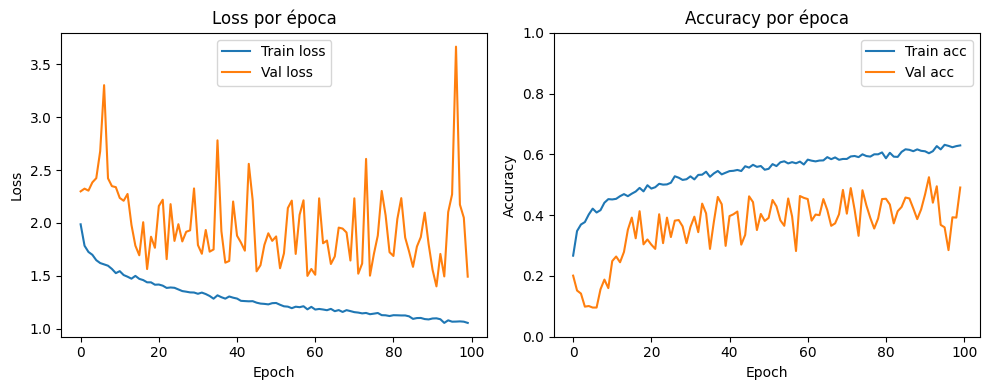

{'Arquitectura': ((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)), 'Optimizador': 'Adam', 'Dropout': 0.0, 'TrainAcc_mean': 0.5431650018692017, 'TrainLoss_mean': 1.279018874168396, 'TestAcc': 0.5074999928474426, 'TestLoss': 1.4174901247024536, 'Execution time': 2871.8508983999927}

=== Widths = ((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)) | Optimizer = RMSprop | Dropout = 0.0 ===

>> Mejor época: 21  train_acc=0.4675  val_acc=0.4240  train_loss=1.4521  val_loss=1.5585  (épocas ejecutadas=41)

--- Estadísticas generales ---
    accuracy: media=0.4591, mediana=0.4712
val_accuracy: media=0.2606, mediana=0.2670
        loss: media=1.4906, mediana=1.4548
    val_loss: media=2.2993, mediana=2.2919


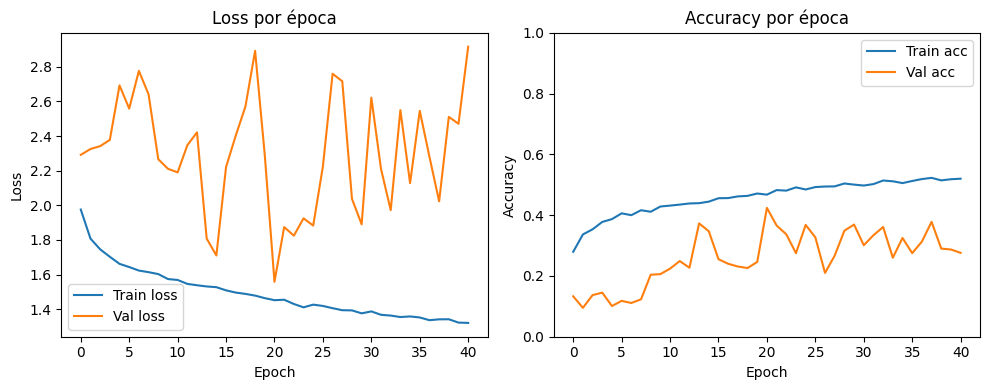

{'Arquitectura': ((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)), 'Optimizador': 'RMSprop', 'Dropout': 0.0, 'TrainAcc_mean': 0.4591219505158866, 'TrainLoss_mean': 1.4905566849359653, 'TestAcc': 0.4372499883174896, 'TestLoss': 1.5364751815795898, 'Execution time': 1126.4028446000011}

=== Widths = ((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)) | Optimizer = SGD | Dropout = 0.0 ===

>> Mejor época: 38  train_acc=0.5120  val_acc=0.4800  train_loss=1.3326  val_loss=1.4428  (épocas ejecutadas=58)

--- Estadísticas generales ---
    accuracy: media=0.4775, mediana=0.4883
val_accuracy: media=0.3337, mediana=0.3430
        loss: media=1.4293, mediana=1.4041
    val_loss: media=2.0485, mediana=1.9797


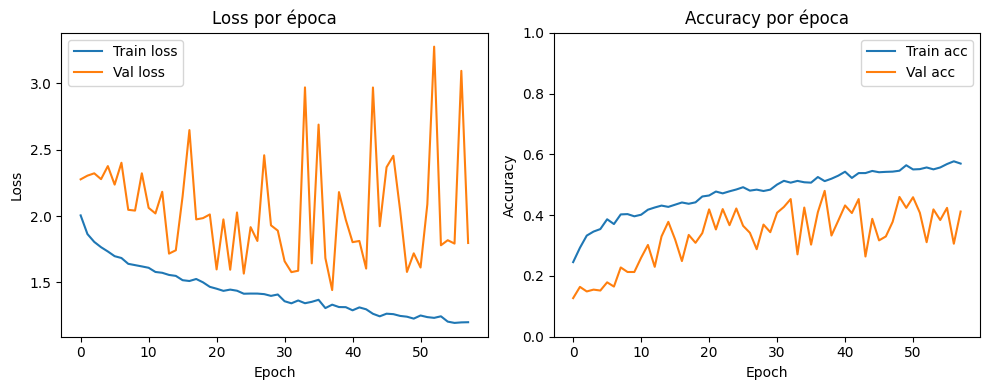

{'Arquitectura': ((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)), 'Optimizador': 'SGD', 'Dropout': 0.0, 'TrainAcc_mean': 0.47746551756201117, 'TrainLoss_mean': 1.4292514118654975, 'TestAcc': 0.4892500042915344, 'TestLoss': 1.432166337966919, 'Execution time': 1641.7466615000012}


In [14]:
for (width, opt, drop) in hyperparams[:3]:
        model, callback, result = fit_one(width, opt, drop)
        models.append((model,callback))
        results.append(result)


=== Widths = ((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001)) | Optimizer = Adam | Dropout = 0.0 ===

>> Mejor época: 46  train_acc=0.5642  val_acc=0.4530  train_loss=1.3058  val_loss=1.7589  (épocas ejecutadas=66)

--- Estadísticas generales ---
    accuracy: media=0.5105, mediana=0.5244
val_accuracy: media=0.2773, mediana=0.2880
        loss: media=1.4625, mediana=1.4080
    val_loss: media=2.6254, mediana=2.5693


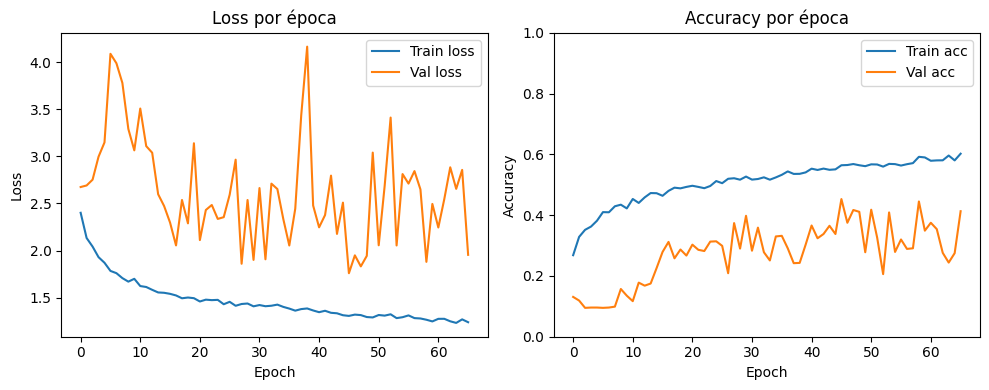

{'Arquitectura': ((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001)), 'Optimizador': 'Adam', 'Dropout': 0.0, 'TrainAcc_mean': 0.5104507578141761, 'TrainLoss_mean': 1.4625473221143086, 'TestAcc': 0.4337500035762787, 'TestLoss': 1.7338885068893433, 'Execution time': 12492.277765899998}

=== Widths = ((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001)) | Optimizer = RMSprop | Dropout = 0.0 ===

>> Mejor época: 32  train_acc=0.4762  val_acc=0.3940  train_loss=1.4991  val_loss=1.9186  (épocas ejecutadas=52)

--- Estadísticas generales ---
    accuracy: media=0.4561, mediana=0.4694
val_accuracy: media=0.2302, mediana=0.2465
        loss: media=1.5886, mediana=1.5230
    val_loss: media=2.9949, mediana=2.9015


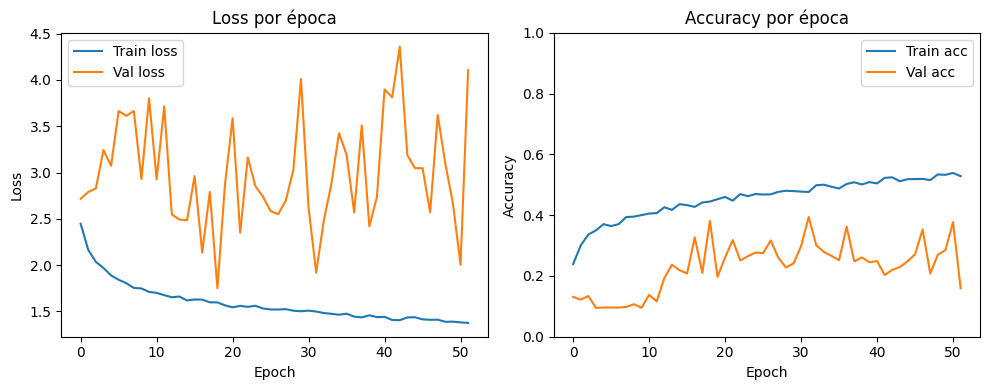

{'Arquitectura': ((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001)), 'Optimizador': 'RMSprop', 'Dropout': 0.0, 'TrainAcc_mean': 0.4560865352933223, 'TrainLoss_mean': 1.5885653449938848, 'TestAcc': 0.4115000069141388, 'TestLoss': 1.905281662940979, 'Execution time': 9713.665823699994}

=== Widths = ((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001)) | Optimizer = SGD | Dropout = 0.0 ===

>> Mejor época: 84  train_acc=0.6260  val_acc=0.5290  train_loss=1.1219  val_loss=1.4634  (épocas ejecutadas=100)

--- Estadísticas generales ---
    accuracy: media=0.5279, mediana=0.5549
val_accuracy: media=0.3721, mediana=0.4075
        loss: media=1.4322, mediana=1.3369
    val_loss: media=2.1954, mediana=2.0299


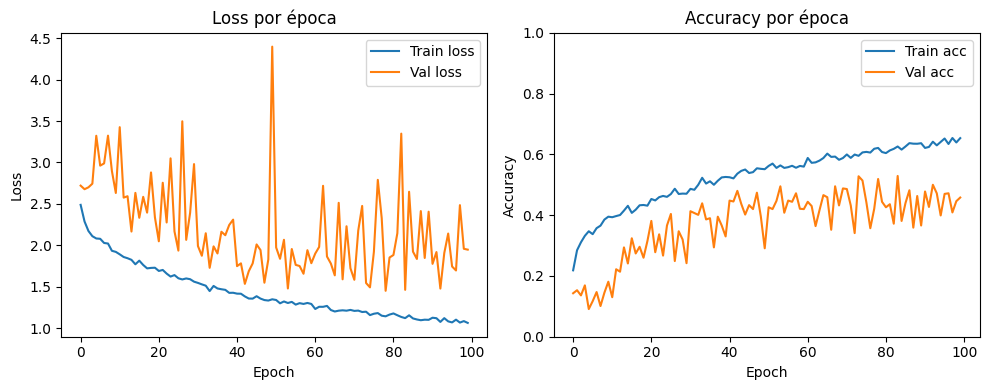

{'Arquitectura': ((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001)), 'Optimizador': 'SGD', 'Dropout': 0.0, 'TrainAcc_mean': 0.5278699989616871, 'TrainLoss_mean': 1.4321796584129334, 'TestAcc': 0.5052499771118164, 'TestLoss': 1.4914180040359497, 'Execution time': 18688.410101999994}


In [15]:
for (width, opt, drop) in hyperparams[3:6]:
        model, callback, result = fit_one(width, opt, drop)
        models.append((model,callback))
        results.append(result)


=== Widths = ((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)) | Optimizer = Adam | Dropout = 0.2 ===

>> Mejor época: 35  train_acc=0.5297  val_acc=0.4300  train_loss=1.3309  val_loss=1.5525  (épocas ejecutadas=55)

--- Estadísticas generales ---
    accuracy: media=0.4882, mediana=0.5077
val_accuracy: media=0.2468, mediana=0.2470
        loss: media=1.4234, mediana=1.3778
    val_loss: media=2.1198, mediana=2.1516


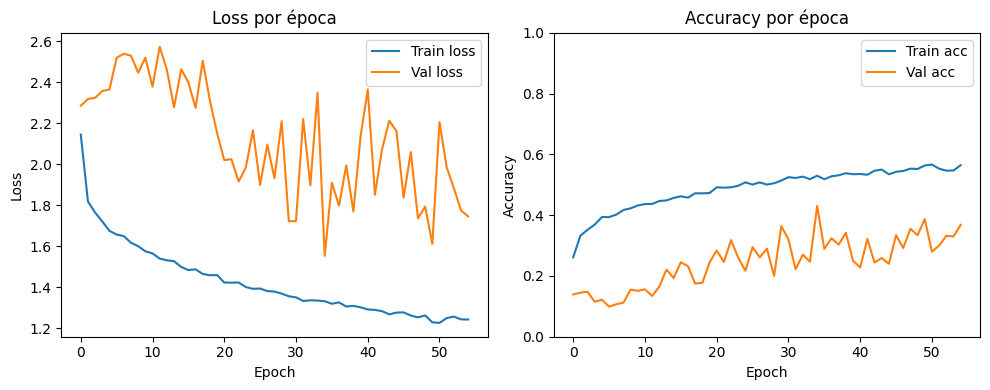

{'Arquitectura': ((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)), 'Optimizador': 'Adam', 'Dropout': 0.2, 'TrainAcc_mean': 0.48817272511395543, 'TrainLoss_mean': 1.4233985380692915, 'TestAcc': 0.4323750138282776, 'TestLoss': 1.5470151901245117, 'Execution time': 2984.2165007000003}

=== Widths = ((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)) | Optimizer = RMSprop | Dropout = 0.35 ===

>> Mejor época: 27  train_acc=0.4827  val_acc=0.2880  train_loss=1.4193  val_loss=1.9104  (épocas ejecutadas=47)

--- Estadísticas generales ---
    accuracy: media=0.4619, mediana=0.4805
val_accuracy: media=0.1490, mediana=0.1460
        loss: media=1.4868, mediana=1.4482
    val_loss: media=2.5793, mediana=2.4816


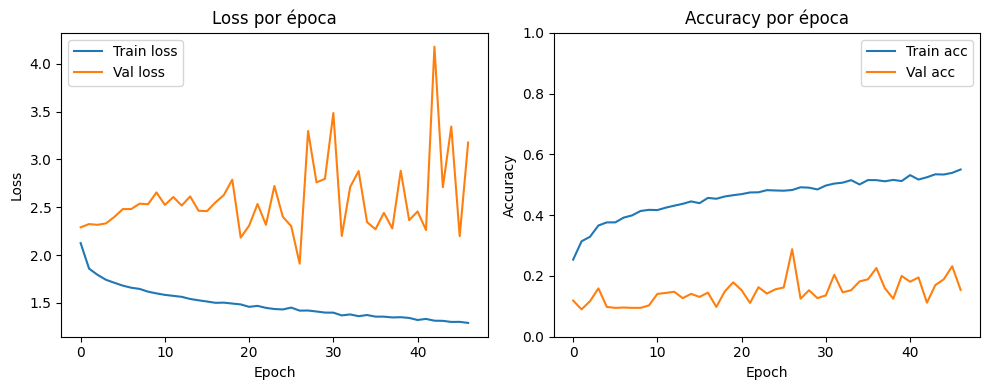

{'Arquitectura': ((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)), 'Optimizador': 'RMSprop', 'Dropout': 0.35, 'TrainAcc_mean': 0.46192021509434317, 'TrainLoss_mean': 1.4867829617033614, 'TestAcc': 0.3050000071525574, 'TestLoss': 1.9073927402496338, 'Execution time': 2461.693075000003}

=== Widths = ((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)) | Optimizer = SGD | Dropout = 0.35 ===

>> Mejor época: 96  train_acc=0.6187  val_acc=0.3650  train_loss=1.0618  val_loss=1.6077  (épocas ejecutadas=100)

--- Estadísticas generales ---
    accuracy: media=0.5132, mediana=0.5372
val_accuracy: media=0.1717, mediana=0.1530
        loss: media=1.3373, mediana=1.2816
    val_loss: media=2.5513, mediana=2.5150


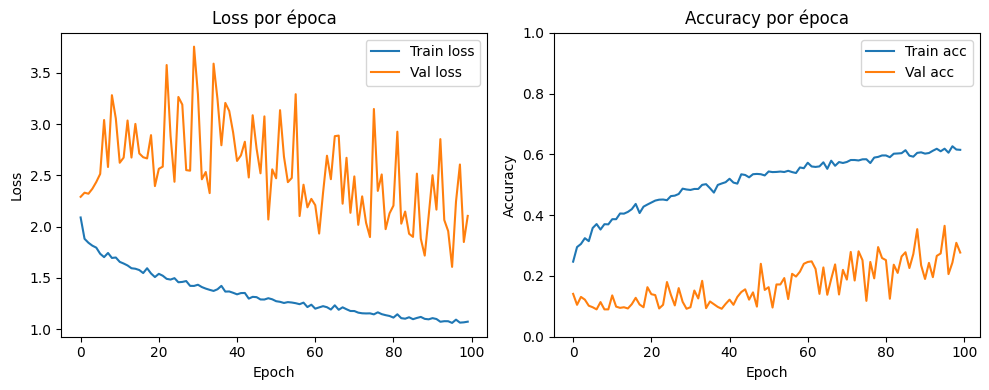

{'Arquitectura': ((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0)), 'Optimizador': 'SGD', 'Dropout': 0.35, 'TrainAcc_mean': 0.5132199965417386, 'TrainLoss_mean': 1.3372511100769042, 'TestAcc': 0.39399999380111694, 'TestLoss': 1.57600736618042, 'Execution time': 5305.738398200003}


In [16]:
for (width, opt, drop) in hyperparams[6:9]:
        model, callback, result = fit_one(width, opt, drop)
        models.append((model,callback))
        results.append(result)        


=== Widths = ((64, 5, True, 0.0), (128, 3, True, 0.0), (256, 3, True, 0.0)) | Optimizer = Adam | Dropout = 0.0 ===

>> Mejor época: 94  train_acc=0.6492  val_acc=0.5630  train_loss=0.9756  val_loss=1.3117  (épocas ejecutadas=100)

--- Estadísticas generales ---
    accuracy: media=0.5613, mediana=0.5809
val_accuracy: media=0.3688, mediana=0.3845
        loss: media=1.2233, mediana=1.1762
    val_loss: media=1.9938, mediana=1.9266


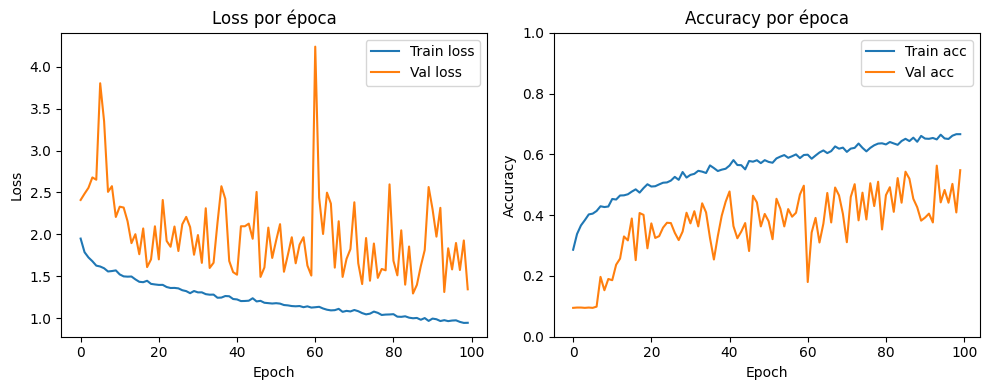

{'Arquitectura': ((64, 5, True, 0.0), (128, 3, True, 0.0), (256, 3, True, 0.0)), 'Optimizador': 'Adam', 'Dropout': 0.0, 'TrainAcc_mean': 0.5613474982976914, 'TrainLoss_mean': 1.2232797646522522, 'TestAcc': 0.5552499890327454, 'TestLoss': 1.2743862867355347, 'Execution time': 6886.8039234000025}

=== Widths = ((64, 5, True, 0.0), (128, 3, True, 0.0), (256, 3, True, 0.0)) | Optimizer = RMSprop | Dropout = 0.0 ===

>> Mejor época: 22  train_acc=0.4815  val_acc=0.4130  train_loss=1.4321  val_loss=1.6188  (épocas ejecutadas=42)

--- Estadísticas generales ---
    accuracy: media=0.4661, mediana=0.4811
val_accuracy: media=0.2447, mediana=0.2480
        loss: media=1.4757, mediana=1.4360
    val_loss: media=2.6258, mediana=2.4891


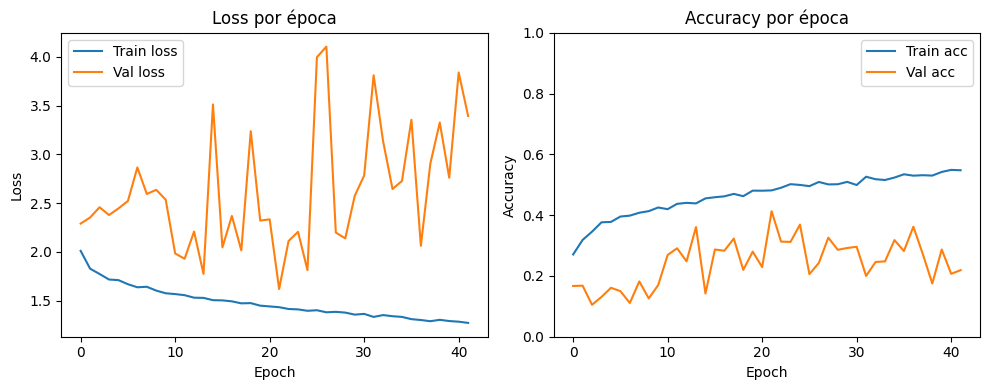

{'Arquitectura': ((64, 5, True, 0.0), (128, 3, True, 0.0), (256, 3, True, 0.0)), 'Optimizador': 'RMSprop', 'Dropout': 0.0, 'TrainAcc_mean': 0.46607737952754613, 'TrainLoss_mean': 1.4757053539866494, 'TestAcc': 0.4078750014305115, 'TestLoss': 1.6190327405929565, 'Execution time': 2896.267410500004}


In [20]:
for (width, opt, drop) in hyperparams[9:]:
        model, callback, result = fit_one(width, opt, drop)
        models.append((model,callback))
        results.append(result)

## Análisis de resultados

Crea una tabla con los resultados de todos los modelos y la formatea para resaltar la mejor precisión y las métricas de test con colores.

In [21]:
df_resultados = pd.DataFrame(results, columns=[
    "Arquitectura","Optimizador","L1","L2","Dropout",
    "TrainAcc_mean","TrainLoss_mean","TestAcc","TestLoss"
])
col_num = df_resultados.select_dtypes(include="number").columns

df_resultados = (
    df_resultados.style
    .set_caption(" RESULTADOS FINALES")
    .background_gradient(cmap="YlGnBu", subset=["TestAcc"])
    .background_gradient(cmap="OrRd", subset=["TestLoss"])
    .highlight_max(color="darkgreen", subset=["TestAcc"])
    .format({col: "{:.4g}".format for col in col_num})
    .set_table_attributes('style="width:100%; table-layout:fixed;"')
)


Muestra resultados.

In [22]:
df_resultados

,Arquitectura,Optimizador,L1,L2,Dropout,TrainAcc_mean,TrainLoss_mean,TestAcc,TestLoss
0,"((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0))",Adam,nan,nan,0,0.5432,1.279,0.5075,1.417
1,"((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0))",RMSprop,nan,nan,0,0.4591,1.491,0.4372,1.536
2,"((32, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0))",SGD,nan,nan,0,0.4775,1.429,0.4893,1.432
3,"((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001))",Adam,nan,nan,0,0.5105,1.463,0.4338,1.734
4,"((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001))",RMSprop,nan,nan,0,0.4561,1.589,0.4115,1.905
5,"((128, 3, True, 0.0), (256, 3, True, 0.0), (512, 3, True, 0.001))",SGD,nan,nan,0,0.5279,1.432,0.5052,1.491
6,"((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0))",Adam,nan,nan,0.2,0.4882,1.423,0.4324,1.547
7,"((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0))",RMSprop,nan,nan,0.35,0.4619,1.487,0.305,1.907
8,"((64, 3, True, 0.0), (64, 3, True, 0.0), (128, 3, True, 0.0))",SGD,nan,nan,0.35,0.5132,1.337,0.394,1.576
9,"((64, 5, True, 0.0), (128, 3, True, 0.0), (256, 3, True, 0.0))",Adam,nan,nan,0,0.5613,1.223,0.5552,1.274


## Modelos preentrenados

Se importan los modelos preentrenados de interés y sus respectivos preprocesados

In [40]:
from keras.applications import ResNet50, InceptionV3, MobileNetV2, EfficientNetB0
from keras.applications.resnet import preprocess_input as resnet_pre
from keras.applications.inception_v3 import preprocess_input as inception_pre
from keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_pre
from keras.applications.efficientnet import preprocess_input as eff_pre

Se crea un diccionario donde las claves son los nombres de los modelos y los valores tienen información de los mismos como su arquitectura, su preprocesado y su tamaño de entradas

In [41]:
BACKBONES = {
    "resnet50":      dict(ctor=ResNet50,      preprocess=resnet_pre,      input_size=(224, 224)),
    "mobilenetv2":   dict(ctor=MobileNetV2,   preprocess=mobilenetv2_pre, input_size=(224, 224)),
    "efficientnetb0":dict(ctor=EfficientNetB0,preprocess=eff_pre,         input_size=(224, 224)),
    "inceptionv3":   dict(ctor=InceptionV3,   preprocess=inception_pre,   input_size=(299, 299)),
}

Se definen las configuraciones que vamos a probar con modelos preentrenados (ResNet50, MobileNetV2, EfficientNetB0 e InceptionV3).  
El backbone nunca se entrena y solo se entrena la cabeza que añadimos encima (capa intermedia + softmax):
- PRE_USE_AUG: True si usamos data augmentation.
- PRE_TRAINABLE: True si se entrena el backbone.
- PRE_POOLING: define donde se hace el pooling global.
- PRE_NUM_CLASSES: número de clases del problema.

Además, hay una lista de hiperparámetros que se prueban para obtener la mejor cabeza posible:
- backbone_key: identificador del modelo.
- hidden_units: tamaño de la capa intermedia.
- dropout_rate: tasa de dropout.
- OPTIMIZER_NAME: nombre del optimizador que se usará para entrenar la cabeza.

In [42]:
PRE_USE_AUG      = True       
PRE_TRAINABLE    = False       
PRE_POOLING      = None       
PRE_NUM_CLASSES  = NUM_CLASSES 

pretrained_hyperparams = [
    (("resnet50", None, 0.0), "Adam"),
    (("mobilenetv2", None, 0.0), "Adam"),
    (("efficientnetb0",None, 0.0), "Adam"),
    (("inceptionv3", None, 0.0), "Adam"),
]

Se reciben las imágenes originales y las adapta al tamaño y formato de entrada requerido por cada modelo

In [43]:
def make_input_block(backbone_key, use_aug=True):
    info = BACKBONES[backbone_key]
    inputs = Input(shape=(96, 96, 3), name=f"{backbone_key}_input96")  

    x = inputs
    if use_aug:
        x = data_augmentation(x) 

    x = layers.Resizing(info["input_size"][0], info["input_size"][1], name=f"{backbone_key}_resize")(x)

    x = layers.Rescaling(255.0, name=f"{backbone_key}_to255")(x)
    x = info["preprocess"](x)
    return inputs, x, info

build_backbone_block: construye el cuerpo preentrenado (backbone) de un modelo usando redes como ResNet50, MobileNetV2 o EfficientNet. Carga el modelo preentrenado sin su cabeza original y marca si el backbone se entrena o no. Devuelve la entrada, las características del backbone y el proprio backbone:
- backbone_key: str -> seleeciona el modelo preentrenado.
- use_agu: bool -> activa/desactiva data augmentation.
- trainable: bool -> indica si se entrena o no.
- pooling: str -> define que tipo de pooling se aplica.  

In [44]:
def build_backbone_block(backbone_key: str, use_aug: bool = PRE_USE_AUG, trainable: bool = PRE_TRAINABLE, pooling: str | None = PRE_POOLING):
    inputs, x_preprocessed, info = make_input_block(backbone_key, use_aug = use_aug)

    BackboneCtor = info["ctor"]
    backbone = BackboneCtor(include_top=False, weights="imagenet", input_shape=(info["input_size"][0], info["input_size"][1], 3), pooling=pooling)

    features = backbone(x_preprocessed)
    backbone.trainable = trainable

    return inputs, features, backbone

build_head: construye la cabeza clasificadora que se añade encima del backbone.  
Aplica el pooling global si el backbone no lo hizo, añade opcionalmente una capa densa intermedia y finaliza con la salida softmax.  
- features: tensor -> salida del backbone.  
- num_classes: int -> número de clases.  
- hidden_units: int/None -> tamaño de la capa intermedia (o None para no usarla).  
- dropout_rate: float -> dropout tras la capa intermedia.  
- already_pooled: bool -> indica si el backbone ya aplicó pooling global.  
- name_prefix: str -> prefijo para nombrar las capas de la cabeza.  


In [45]:
def build_head(features, num_classes: int = PRE_NUM_CLASSES, hidden_units: int | None = None, dropout_rate: float = None, already_pooled: bool = False, name_prefix: str = "head"):
    x = features

    if not already_pooled:
        x = layers.GlobalAveragePooling2D(name=f"{name_prefix}_gap")(x)

    if hidden_units and hidden_units > 0:
        x = layers.Dense(hidden_units, activation='relu', name=f"{name_prefix}_dense")(x)
        if dropout_rate and dropout_rate > 0.0:
            x = layers.Dropout(dropout_rate, name=f"{name_prefix}_dropout")(x)

    outputs = layers.Dense(num_classes, activation='softmax', name=f"{name_prefix}_output")(x)
    
    return outputs

In [46]:
def build_pretrained_model(backbone_key, hidden_units, dropout_rate, optimizer_name, use_aug=PRE_USE_AUG, trainable=PRE_TRAINABLE, pooling=PRE_POOLING, use_early_stopping=USE_EARLY_STOPPING, patience=PATIENCE):

    inputs, features, backbone = build_backbone_block(backbone_key=backbone_key, use_aug=use_aug, trainable=trainable, pooling=pooling)

    if pooling == "avg" or pooling == "max":
        already_pooled = True
    else:
        already_pooled = False

    outputs = build_head(features, num_classes=PRE_NUM_CLASSES, hidden_units=hidden_units, dropout_rate=dropout_rate, already_pooled=already_pooled, name_prefix=f"{backbone_key}_head")

    model = Model(inputs=inputs, outputs=outputs,  name=f"PT_{backbone_key}_{hidden_units}_{dropout_rate}_{optimizer_name}")

    if optimizer_name == "Adam":
        optimizer = tf.keras.optimizers.Adam()
    elif optimizer_name == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop()
    elif optimizer_name == "SGD":
        optimizer = tf.keras.optimizers.SGD()
    else:
        optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

    if use_early_stopping:
        if patience is None:
            patience = PATIENCE

        early_stop = callbacks.EarlyStopping(
            monitor='val_accuracy',
            mode='max',
            patience=int(patience),
            min_delta=1e-4,
            restore_best_weights=True
        )
        return model, early_stop
    
    return model


In [47]:
def fit_one_pretrained(config, optimizer_name, EPOCHS=EPOCHS, show_stats=True):
    backbone_key, hidden_units, dropout_rate = config

    out  = build_pretrained_model(backbone_key=backbone_key, hidden_units=hidden_units, dropout_rate=dropout_rate, optimizer_name=optimizer_name)

    if isinstance(out, tuple):
        model, early_stop = out
        cbs = [early_stop]
    else:
        model = out
        cbs = []


    start = time.perf_counter()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=0
    )

    train_time = time.perf_counter() - start
    hist = history.history

    if show_stats:
        best_ep = stats(hist)         
    else:
        best_ep = int(np.argmax(hist["val_accuracy"]))

    test_loss, test_acc = model.evaluate(test_ds, verbose=0)

    results = {
        "ModelName": model.name,
        "Backbone": backbone_key,
        "HiddenUnits": hidden_units,
        "Dropout": float(dropout_rate),
        "Optimizer": optimizer_name,
        "BestEpoch": int(best_ep + 1),
        "BestValAcc": float(hist["val_accuracy"][best_ep]),
        "TrainAcc_mean": float(np.mean(hist["accuracy"])),
        "TrainLoss_mean": float(np.mean(hist["loss"])),
        "TestAcc": float(test_acc),
        "TestLoss": float(test_loss),
        "TrainTime": float(train_time),
    }

    return model, results

In [48]:
models_pretrained = []
results_pretrained = []


[PRETRAINED] (1/4) Empiezo modelo
[PRETRAINED]   Backbone   = resnet50
[PRETRAINED]   HiddenUnits= None
[PRETRAINED]   Dropout    = 0.0
[PRETRAINED]   Optimizer  = Adam


>> Mejor época: 11  train_acc=0.9222  val_acc=0.9670  train_loss=0.2352  val_loss=0.1225  (épocas ejecutadas=31)

--- Estadísticas generales ---
    accuracy: media=0.9100, mediana=0.9302
val_accuracy: media=0.9570, mediana=0.9590
        loss: media=0.2642, mediana=0.2055
    val_loss: media=0.1368, mediana=0.1234


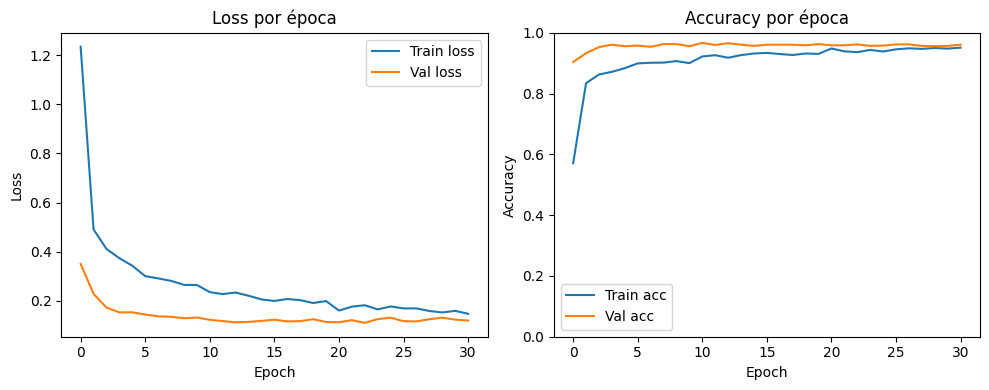


[PRETRAINED]   FIN modelo: PT_resnet50_None_0.0_Adam
[PRETRAINED]   BestValAcc = 0.9670
[PRETRAINED]   TestAcc    = 0.9517
[PRETRAINED]   TrainTime  = 5463.3 s
----------------------------------------------------------------------


[PRETRAINED] (2/4) Empiezo modelo
[PRETRAINED]   Backbone   = mobilenetv2
[PRETRAINED]   HiddenUnits= None
[PRETRAINED]   Dropout    = 0.0
[PRETRAINED]   Optimizer  = Adam


>> Mejor época: 20  train_acc=0.8848  val_acc=0.9490  train_loss=0.3305  val_loss=0.2027  (épocas ejecutadas=40)

--- Estadísticas generales ---
    accuracy: media=0.8731, mediana=0.8909
val_accuracy: media=0.9364, mediana=0.9400
        loss: media=0.3778, mediana=0.3185
    val_loss: media=0.2377, mediana=0.2108


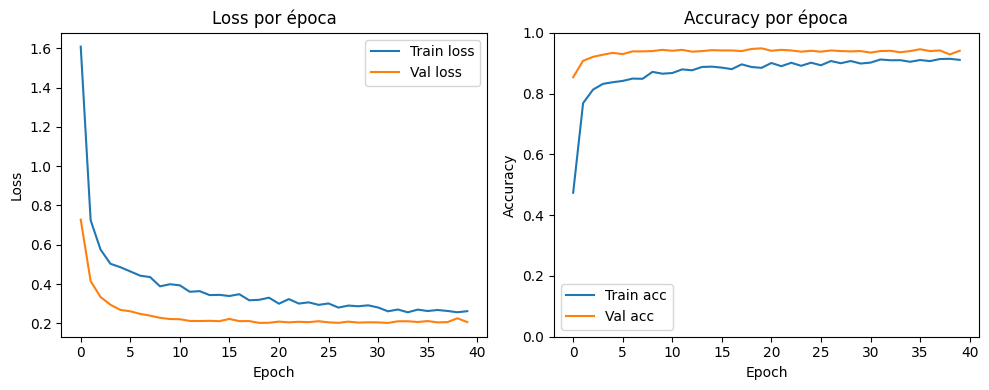


[PRETRAINED]   FIN modelo: PT_mobilenetv2_None_0.0_Adam
[PRETRAINED]   BestValAcc = 0.9490
[PRETRAINED]   TestAcc    = 0.9449
[PRETRAINED]   TrainTime  = 2662.5 s
----------------------------------------------------------------------


[PRETRAINED] (3/4) Empiezo modelo
[PRETRAINED]   Backbone   = efficientnetb0
[PRETRAINED]   HiddenUnits= None
[PRETRAINED]   Dropout    = 0.0
[PRETRAINED]   Optimizer  = Adam



ValueError: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)

In [50]:
num_models = len(pretrained_hyperparams)

for idx, (config, optimizer_name) in enumerate(pretrained_hyperparams, start=1):
    backbone_key, hidden_units, dropout_rate = config

    print("\n" + "="*70)
    print(f"[PRETRAINED] ({idx}/{num_models}) Empiezo modelo")
    print(f"[PRETRAINED]   Backbone   = {backbone_key}")
    print(f"[PRETRAINED]   HiddenUnits= {hidden_units}")
    print(f"[PRETRAINED]   Dropout    = {dropout_rate}")
    print(f"[PRETRAINED]   Optimizer  = {optimizer_name}")
    print("="*70 + "\n")

    model, result = fit_one_pretrained(
        config,
        optimizer_name,
        EPOCHS=EPOCHS,
        show_stats=True  
    )

    print(f"\n[PRETRAINED]   FIN modelo: {result['ModelName']}")
    print(f"[PRETRAINED]   BestValAcc = {result['BestValAcc']:.4f}")
    print(f"[PRETRAINED]   TestAcc    = {result['TestAcc']:.4f}")
    print(f"[PRETRAINED]   TrainTime  = {result['TrainTime']:.1f} s")
    print("-"*70 + "\n")

    models_pretrained.append(model)
    results_pretrained.append(result)